In [1]:
## LOAD Libraries 

# IMPORT
import pandas as pd
import numpy as np
import pprint
import itertools
import time
import pyreadr
import sklearn
import matplotlib.pyplot as plt
import shap
from sklearn.feature_selection import RFE
import random
import os
import joblib
from numpy import mean, std
from collections import Counter
import warnings



# Random Forest imports
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
import sklearn.metrics as metricsfrom sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import plot_roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV, f_classif
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,StratifiedKFold,RandomizedSearchCV



# evaluate RFE for classification
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

## filter 
from sklearn.feature_selection import mutual_info_classif, SelectKBest, chi2


from numpy.random import seed


#### Load train and validation Data

In [20]:
X_corr = pd.read_csv("Input/dfXtr_corr.csv")
X_corr.set_index("Unnamed: 0", inplace=True)
X_corr.index.name=None
X_corr.head()


X_val =  pd.read_csv('Input/dfVal_corr.csv')
X_val.set_index("Unnamed: 0", inplace=True)
X_val.index.name=None
X_val.head()


y = pd.read_csv("Input/dfy.csv",header=None)
y = y.set_index(0)
y.index.name = None
y = y[1]

y_val = pd.read_csv("Input/dfyval.csv",header=None)
y_val = y_val.set_index(0)
y_val.index.name = None
y_val = y_val[1]

# print(X.shape)
# print(X_val.shape)
# print(y.shape)
# print(y_val.shape)

(50, 425006)
(444,)
(50,)


In [23]:
## Create BAPS df for group split

baps = pd.read_csv("Input/hierBAPS.txt", index_col=0)
baps = baps.set_index("Isolate")
baps["level 1"] = baps["level 1"]-1


         level 1  level 2
Isolate                  
PA10           0        1
PA1012         1        3
PA1013         1        3
PA1014         1        3
PA1015         1        3


In [9]:

def group_split(X,y,group):
    gss = GroupShuffleSplit(n_splits=16, test_size=.2, random_state=None)
    for train_index, test_index in gss.split(X,y,group):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        return X_train, X_test, y_train, y_test

In [10]:
## Save train/test splits

random.seed(12345)

start_time = time.time()

ukp_gr = baps.merge(X_corr,right_index=True,left_index=True)
ukp_gr = ukp_gr.sort_values(by=["level 1"])
group = ukp_gr["level 1"]
X_corr = ukp_gr.drop(["level 1","level 2"], axis=1)

trainlist = {}

i=0
gss = GroupShuffleSplit(n_splits=16, test_size=.15, random_state=12345)
        #     group_kfold = GroupKFold(n_splits=10,shuffle=False)
for train_index, test_index in gss.split(X_corr,y,group):
    X_train, X_test = X_corr.iloc[train_index], X_corr.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print(X_test.shape)
    i+=1
    trainlist[i] = list(X_train.index)
# print(pd.DataFrame.from_dict(trainlist))
pd.DataFrame.from_dict(trainlist,orient='index').to_csv("OutputNewNCV/OuterGroupRFECV/TrainGroupSplit2.csv")

(62, 4800)
(51, 4800)
(67, 4800)
(44, 4800)
(61, 4800)
(57, 4800)
(77, 4800)
(68, 4800)
(52, 4800)
(53, 4800)
(171, 4800)
(64, 4800)
(65, 4800)
(63, 4800)
(159, 4800)
(181, 4800)


(62, 4800)
0.45930515063168126
Accuracy:  0.6935483870967742
TestAUC:  0.5
TrainAUC:  0.5688486248038606
(51, 4800)


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


0.468735632183908
Accuracy:  0.5686274509803921
TestAUC:  0.44821428571428573
TrainAUC:  0.9964788732394366
(67, 4800)
0.5272108843537414
Accuracy:  0.6716417910447762
TestAUC:  0.5
TrainAUC:  0.5684342201610935
(44, 4800)


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


0.4383012820512821
Accuracy:  0.5681818181818182
TestAUC:  0.5
TrainAUC:  0.5801152181702913
(61, 4800)


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


0.5053449951409136
Accuracy:  0.639344262295082
TestAUC:  0.5075187969924813
TrainAUC:  0.9388489208633093
(57, 4800)
0.5091666666666667
Accuracy:  0.6491228070175439
TestAUC:  0.5
TrainAUC:  0.5849484896106163
(77, 4800)


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


0.44247438928289995
Accuracy:  0.6883116883116883
TestAUC:  0.5341981132075472
TrainAUC:  0.9925373134328358
(68, 4800)
0.47694633408919124
Accuracy:  0.6323529411764706
TestAUC:  0.5083720930232558
TrainAUC:  0.8195488721804511
(52, 4800)
0.45098039215686275
Accuracy:  0.6153846153846154
TestAUC:  0.5238095238095238
TrainAUC:  0.948905109489051
(53, 4800)
0.47152194211017734
Accuracy:  0.6037735849056604
TestAUC:  0.48484848484848486
TrainAUC:  0.7911725955204216
(171, 4800)
0.4505135387488329
Accuracy:  0.6491228070175439
TestAUC:  0.46638655462184875
TrainAUC:  0.8301886792452831
(64, 4800)
0.500251952632905
Accuracy:  0.609375
TestAUC:  0.4875
TrainAUC:  0.9477611940298507
(65, 4800)
0.46166666666666667
Accuracy:  0.5692307692307692
TestAUC:  0.5
TrainAUC:  0.5882916280506642
(63, 4800)


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


0.5259259259259259
Accuracy:  0.6349206349206349
TestAUC:  0.5088691796008868
TrainAUC:  0.9926470588235294
(159, 4800)
0.4905202821869488
Accuracy:  0.6540880503144654
TestAUC:  0.5
TrainAUC:  0.6137576016216792
(181, 4800)


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


0.5291537667698658
Accuracy:  0.6353591160220995
TestAUC:  0.5
TrainAUC:  0.6028476989575388


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


(62, 4800)
0.45930515063168126
Accuracy:  0.6935483870967742
TestAUC:  0.5
TrainAUC:  0.566272907599846
(51, 4800)


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


0.468735632183908
Accuracy:  0.6274509803921569
TestAUC:  0.5080357142857143
TrainAUC:  0.9894366197183099
(67, 4800)
0.5272108843537414
Accuracy:  0.6716417910447762
TestAUC:  0.5
TrainAUC:  0.5826671955089089
(44, 4800)


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


0.4383012820512821
Accuracy:  0.5681818181818182
TestAUC:  0.5
TrainAUC:  0.5762838005457703
(61, 4800)


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


0.5053449951409136
Accuracy:  0.6229508196721312
TestAUC:  0.5244360902255639
TrainAUC:  0.9460431654676259
(57, 4800)
0.5091666666666667
Accuracy:  0.6666666666666666
TestAUC:  0.525
TrainAUC:  0.5841627379081543
(77, 4800)
0.44247438928289995
Accuracy:  0.6623376623376623
TestAUC:  0.4811320754716981
TrainAUC:  0.9925373134328358
(68, 4800)
0.47694633408919124
Accuracy:  0.6176470588235294
TestAUC:  0.4883720930232558
TrainAUC:  0.7983384386893159
(52, 4800)
0.45098039215686275
Accuracy:  0.5961538461538461
TestAUC:  0.5076804915514593
TrainAUC:  0.9562043795620438
(53, 4800)
0.47152194211017734
Accuracy:  0.6226415094339622
TestAUC:  0.5
TrainAUC:  0.7987483530961792
(171, 4800)


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


0.4505135387488329
Accuracy:  0.7192982456140351
TestAUC:  0.5547026502908855
TrainAUC:  0.8113207547169812
(64, 4800)
0.500251952632905
Accuracy:  0.59375
TestAUC:  0.5166666666666666
TrainAUC:  0.9267382599199125
(65, 4800)
0.46166666666666667
Accuracy:  0.5692307692307692
TestAUC:  0.5
TrainAUC:  0.5844454742045103
(63, 4800)


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


0.5259259259259259
Accuracy:  0.5873015873015873
TestAUC:  0.4828159645232815
TrainAUC:  0.9926470588235294
(159, 4800)
0.4905202821869488
Accuracy:  0.6540880503144654
TestAUC:  0.5
TrainAUC:  0.63674917315694
(181, 4800)


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


0.5291537667698658
Accuracy:  0.6187845303867403
TestAUC:  0.48695652173913045
TrainAUC:  0.6216628527841342
(62, 4800)
0.45930515063168126
Accuracy:  0.6935483870967742
TestAUC:  0.5
TrainAUC:  0.5755247653728869
(51, 4800)


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


0.468735632183908
Accuracy:  0.5686274509803921
TestAUC:  0.43125
TrainAUC:  0.9819314292127266
(67, 4800)
0.5272108843537414
Accuracy:  0.582089552238806
TestAUC:  0.47979797979797983
TrainAUC:  0.5721106907493287
(44, 4800)
0.4383012820512821
Accuracy:  0.5681818181818182
TestAUC:  0.5
TrainAUC:  0.5870751674522451
(61, 4800)


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


0.5053449951409136
Accuracy:  0.6065573770491803
TestAUC:  0.5845864661654134
TrainAUC:  0.8972313952116995
(57, 4800)
0.5091666666666667
Accuracy:  0.6666666666666666
TestAUC:  0.525
TrainAUC:  0.5825475816308713
(77, 4800)
0.44247438928289995
Accuracy:  0.6883116883116883
TestAUC:  0.5569968553459119
TrainAUC:  0.9850746268656716
(68, 4800)
0.47694633408919124
Accuracy:  0.5735294117647058
TestAUC:  0.4702325581395349
TrainAUC:  0.7983384386893159
(52, 4800)
0.45098039215686275
Accuracy:  0.6153846153846154
TestAUC:  0.5314900153609832
TrainAUC:  0.9449835408616001
(53, 4800)
0.47152194211017734
Accuracy:  0.6226415094339622
TestAUC:  0.5196969696969698
TrainAUC:  0.7598814229249012
(171, 4800)
0.4505135387488329
Accuracy:  0.7017543859649122
TestAUC:  0.5475113122171945
TrainAUC:  0.820754716981132
(64, 4800)
0.500251952632905
Accuracy:  0.640625
TestAUC:  0.5708333333333333
TrainAUC:  0.9223395219026816
(65, 4800)
0.46166666666666667
Accuracy:  0.5692307692307692
TestAUC:  0.5
Trai

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


0.5259259259259259
Accuracy:  0.5714285714285714
TestAUC:  0.47062084257206205
TrainAUC:  0.9738595438175272
(159, 4800)
0.4905202821869488
Accuracy:  0.6415094339622641
TestAUC:  0.49895104895104897
TrainAUC:  0.5936999893310572
(181, 4800)
0.5291537667698658
Accuracy:  0.6022099447513812
TestAUC:  0.483596837944664
TrainAUC:  0.6162280701754385
(62, 4800)
0.45930515063168126
Accuracy:  0.6935483870967742
TestAUC:  0.5
TrainAUC:  0.5359564200491459
(51, 4800)


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


0.468735632183908
Accuracy:  0.5882352941176471
TestAUC:  0.49642857142857144
TrainAUC:  0.8508641490376524
(67, 4800)
0.5272108843537414
Accuracy:  0.6716417910447762
TestAUC:  0.5
TrainAUC:  0.5871826946546252
(44, 4800)


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


0.4383012820512821
Accuracy:  0.5681818181818182
TestAUC:  0.5
TrainAUC:  0.563576724827035
(61, 4800)


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


0.5053449951409136
Accuracy:  0.7213114754098361
TestAUC:  0.6535087719298246
TrainAUC:  0.828429060030664
(57, 4800)
0.5091666666666667
Accuracy:  0.6491228070175439
TestAUC:  0.522972972972973
TrainAUC:  0.573729701414353
(77, 4800)
0.44247438928289995
Accuracy:  0.6103896103896104
TestAUC:  0.48899371069182396
TrainAUC:  0.8793799244122735
(68, 4800)
0.47694633408919124
Accuracy:  0.5882352941176471
TestAUC:  0.5069767441860464
TrainAUC:  0.7183235867446394
(52, 4800)
0.45098039215686275
Accuracy:  0.5384615384615384
TestAUC:  0.5130568356374807
TrainAUC:  0.8462287104622871
(53, 4800)
0.47152194211017734
Accuracy:  0.6226415094339622
TestAUC:  0.5098484848484849
TrainAUC:  0.6989459815546771
(171, 4800)
0.4505135387488329
Accuracy:  0.6257309941520468
TestAUC:  0.5091305753070459
TrainAUC:  0.7281380634956502
(64, 4800)
0.500251952632905
Accuracy:  0.578125
TestAUC:  0.47916666666666663
TrainAUC:  0.81582938963718
(65, 4800)
0.46166666666666667
Accuracy:  0.5384615384615384
TestAUC

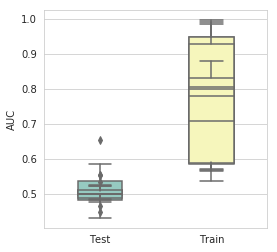

In [12]:
## Nested Cross Validation with PSc (blocking)

random.seed(12345)

start_time = time.time()

ukp_gr = baps.merge(X_corr,right_index=True,left_index=True)
ukp_gr = ukp_gr.sort_values(by=["level 1"])
group = ukp_gr["level 1"]
X_corr = ukp_gr.drop(["level 1","level 2"], axis=1)

for n in [100,50,30,10]:
    trainlist = {}
    auroc_te = {}
    auroc_tr = {}
    ClasRep =  pd.DataFrame()
    TPredictions = {}
    tPredictions = {}
    inner_auc = {}
    Features = list()
    i=0
    gss = GroupShuffleSplit(n_splits=16, test_size=.15, random_state=12345)
    for train_index, test_index in gss.split(X_corr,y,group):
        X_train, X_test = X_corr.iloc[train_index], X_corr.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        print(X_test.shape)
        i+=1
        trainlist[i] = list(X_train.index)

        ## CV inner
       
        features = list()  
        rf_te_roc_auc = list()
        rf_tr_roc_auc = list()
        acc = list()
        inner_score=list()

        ## inner split 

        sss = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=12345)
        rf = RandomForestClassifier(random_state=1)
   
        ## define search space ##
        space = dict()
        space['n_estimators'] = [50, 100, 250,300]
        space['max_depth'] = [4, 6, 8,10]
        search = GridSearchCV(rf, space, scoring='roc_auc', cv=sss, refit=True)
        search.fit(X_train,y_train)
        rf_cv = search.best_estimator_
        print(search.best_score_)
        inner_auc[i]=search.best_score_
        n_features_to_select = n  # Minimum number of features to consider
        rfe = RFE(estimator=rf_cv,n_features_to_select=n_features_to_select,step=10) ## Recursive feature elimination
        rfe.fit(X_train, y_train)


        ## Extract selected features ##

        f = rfe.get_support(1)
        X_tr_rfe = X_train[X_train.columns[f]] 
        X_te_rfe = X_test[X_train.columns[f]] 

        ## fit RF on training with selected features ##
        
        rf_rfe = rf_cv.fit(X_tr_rfe,y_train)
        yhat = rf_rfe.predict(X_te_rfe)
        yThat = rf_rfe.predict(X_tr_rfe)
        Features.append(list(X_te_rfe.columns))
        
        ## evaluate the model ##

        acc = accuracy_score(y_test, yhat)
        print("Accuracy: ",acc)
       
        ## AUROC ##
        rf_roc_auc = roc_auc_score(y_test,yhat)
        print("TestAUC: ",rf_roc_auc)
        auroc_te[i]= (rf_roc_auc) 
        rf_roc_auc = roc_auc_score(y_train,yThat)
        print("TrainAUC: ",rf_roc_auc)
        auroc_tr[i]= (rf_roc_auc) 
        
        ## Save Test Predictions
        data = {'Index': (y_test.index),
                'AET':y_test,
                    'Predictions':yhat, 
                   "Split":"Test",
                   "Iteration":i}
        Ptest = pd.DataFrame(data)
        tPredictions[i] = Ptest
        
        ## Save Train Predictions
        
        data = {'Index': (y_train.index),
                    'AET':y_train,
                        'Predictions':yThat, 
                       "Split":"Train",
                       "Iteration":i}
        Ptrain = pd.DataFrame(data)
        TPredictions[i] = Ptrain

        ## Scores ##
        cr = (classification_report(y_test, yhat,output_dict=True))
        cr = pd.DataFrame.from_dict(cr).T
        ClasRep = pd.concat([ClasRep,cr])
    
    path="OutputNCV/OuterGroupRFECV/RFE_CORR/nselect"+str(n)+"/"
   
    ## Save AUC ##
    
    AUROCt = pd.DataFrame.from_dict(auroc_te, orient='index')
    AUROCt.to_csv(path+"testAUC.csv")
    AUROCT = pd.DataFrame.from_dict(auroc_tr, orient='index')
    AUROCT.to_csv(path+"trainAUC.csv")
    
    ## Figure
    AUROCt["Split"] = "Test"
    AUROCT["Split"] = "Train"
    auc = pd.concat([AUROCt,AUROCT])

    plt.rcParams["figure.figsize"] = (4,4)
    sns.set_style("whitegrid")
    fig=sns.boxplot(data=auc,x='Split',y=0,palette="Set3",width=0.4)
    plt.xlabel('')
    plt.ylabel('AUC')
    plt.savefig(path+"TrTeAUC.png",dpi=450)
    
    
    ### Select Features ###
    
    pd.DataFrame(Features).to_csv(path+"SelectedFeatures.csv")
    import itertools
    merged = list(itertools.chain(*Features))
    selected_uq_features = (set(merged))
    pd.DataFrame(selected_uq_features).to_csv(path+"SelectedUqFeatures.csv")

    #### Select features from auc > 0.7
    
    auc07 = list(auc[auc[0]>0.7].index)
    auc07 = [x - 1 for x in auc07]
    feats = pd.DataFrame(Features)
    feats_auc=pd.DataFrame()
    for n in auc07:
        a = (feats[feats.index==n])
        feats_auc = pd.concat([feats_auc,a])
    feats_auc.to_csv(path+"SelectedFeatures_auc07.csv")
    feats_auc = feats_auc.values.tolist()
    merged = list(itertools.chain(*feats_auc))
    selected_uq_features_auc07 = (set(merged))
    pd.DataFrame(selected_uq_features_auc07).to_csv(path+"SelectedUqFeatures_auc07.csv")


    ## Save Outer Classification Report ##
    ClasRep.to_csv(path+"ClassReport.csv")
    

    
print("--- %s seconds ---" % (time.time() - start_time))


#### Cross Validation with Selected Features

In [24]:
# random.seed(12345)

for i in ["100","50","30","10"]:
    selected_uq_features = list(pd.read_csv("OutputNCV/RFE_CORR/nselect"+str(i)+"/SelectedUqFeatures_auc07.csv")["0"])
    ### Selected Features from NCV
    X_sel = X_corr[selected_uq_features]
    Xval_sel = X_val[selected_uq_features]

    ClasRep =  pd.DataFrame()

    ### Fit on whole training data ## 
    ### Test on validation/hold out data set ##


    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.15)#, random_state=12345)
    rf = RandomForestClassifier(random_state=12345)
    #         # define search space
    space = dict()
    space['n_estimators'] = [50, 100,200, 250,300]
    space['max_depth'] = [4, 6, 8,10]
    search = GridSearchCV(rf, space, scoring='roc_auc', cv=sss, refit=True)
    search.fit(X_sel,y)
    cv_results = search.cv_results_
    rf_cv = search.best_estimator_
    yhat = rf_cv.predict(Xval_sel)
    probas_ = rf_cv.predict_proba(Xval_sel)
    yThat = rf_cv.predict(X_sel)

    ## Features Importance ##
    features = X_sel.columns
    # Fmodels[i] = rf_rfe
    importances = rf_cv.feature_importances_
    indices = np.argsort(importances)[::-1]
    feat_imp_RF = (pd.DataFrame(np.flipud([features[z] for z in indices])))
    feat_imp_RF['Importance'] = importances

        ## Feature Permutation 
    resultp = permutation_importance(rf_cv, Xval_sel, y_val, n_repeats=500, n_jobs=-1)
    perm_sorted_idx = resultp.importances_mean.argsort()
    permutations = pd.DataFrame({'Feature':Xval_sel.columns.values[perm_sorted_idx][::-1],'Mean':resultp.importances_mean[perm_sorted_idx][::-1],
                          'std':resultp.importances_std[perm_sorted_idx][::-1]})
    PermutResults = permutations

    ## evaluate the model ##
    print("Testing on validation set: ")
    acc = accuracy_score(y_val, yhat)
    print(acc)

    ## AUROC test ##
    rf_roc_auc = roc_auc_score(y_val,yhat)

    print("Test AUC"+str(rf_roc_auc))
    auroc_te = (rf_roc_auc) 

    ## AUROC train ##
    rf_roc_auc = roc_auc_score(y,yThat)
    print("Train AUC"+str(rf_roc_auc))
    auroc_tr = (rf_roc_auc) 

    ## Save Test Predictions
    data = {'Index': (y_val.index),
                'AET':y_val,
                    'Predictions':yhat, 
                   "Split":"Test",
                   "Iteration":i}
    Ptest = pd.DataFrame(data)
    tPredictions = Ptest
        ## Save Train Predictions
    data = {'Index': (y.index),
                    'AET':y,
                        'Predictions':yThat, 
                       "Split":"Train",
                       "Iteration":i}
    Ptrain = pd.DataFrame(data)
    TPredictions = Ptrain
    
    ## Scores ##
    cr = (classification_report(y_val, yhat,output_dict=True))
    cr = pd.DataFrame.from_dict(cr).T
    ClasRep = pd.concat([ClasRep,cr])

#     path="OutputNewNCV/OuterGroupRFECV/RFE_CORR2/nselect"+str(i)+"/Fall/"
    ## Save Feature Importance
    df = pd.DataFrame.from_dict(feat_imp_RF).sort_values(by=['Importance'],ascending=False)
#     df = df[df['Importance'].cumsum() < 0.8]
#     df.to_csv(path+"FeatureImportance.csv")

    ## Save Permutation Importance
#     PermutResults.to_csv(path+"PermutResults.csv")

    ## Save Classification Report
#     ClasRep.to_csv(path+"ClasRep.csv")

    ## Save AUC
#     pd.DataFrame([auroc_te]).to_csv(path+"AUROCtest.csv")
#     pd.DataFrame([auroc_tr]).to_csv(path+"AUROCtrain.csv")
    
    ## Save Individual Predictions
#     pd.DataFrame(TPredictions).to_csv(path+"TPredictions.csv")
#     pd.DataFrame(tPredictions).to_csv(path+"tPredictions.csv")
    

Testing on validation set: 
0.88
Test AUC0.8576388888888888
Train AUC0.9968354430379747
Testing on validation set: 
0.84
Test AUC0.8020833333333333
Train AUC1.0
Testing on validation set: 
0.84
Test AUC0.8020833333333333
Train AUC1.0
Testing on validation set: 
0.8
Test AUC0.7586805555555556
Train AUC0.9936708860759493


### Further reduce number of features

66


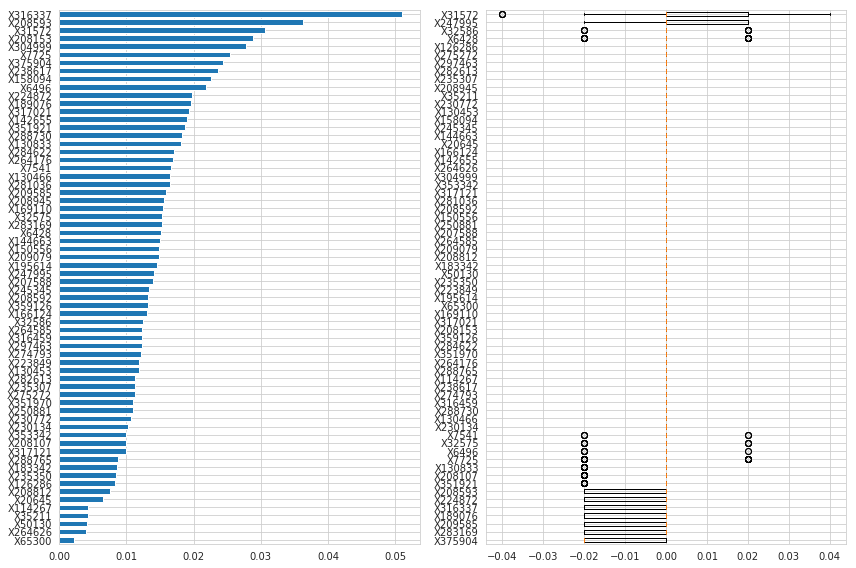

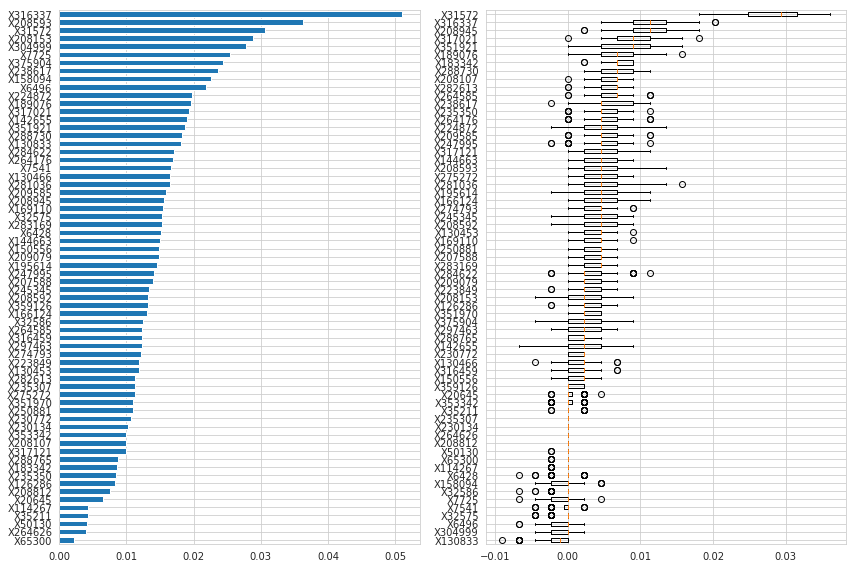

0.86
Test AUC0.8177083333333333
Train AUC0.9824289634416217
40


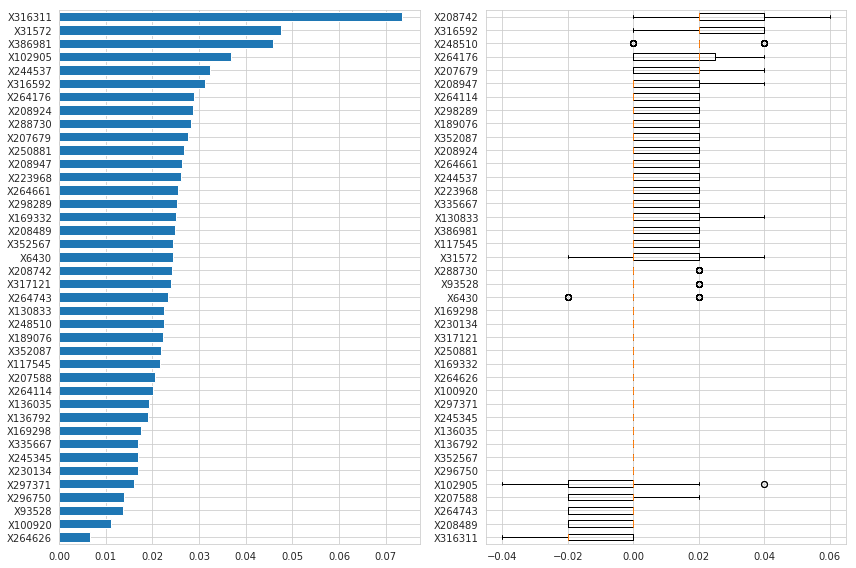

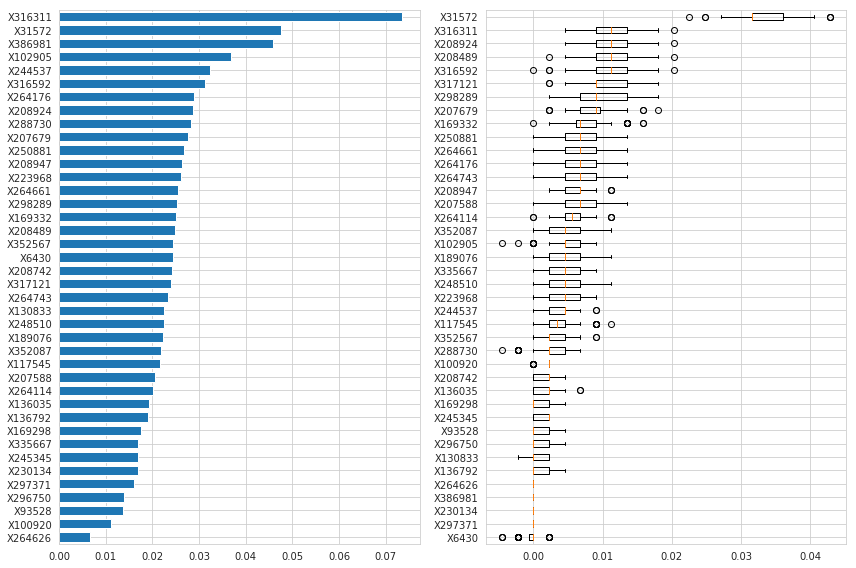

0.88
Test AUC0.8454861111111112
Train AUC0.9873417721518987
30


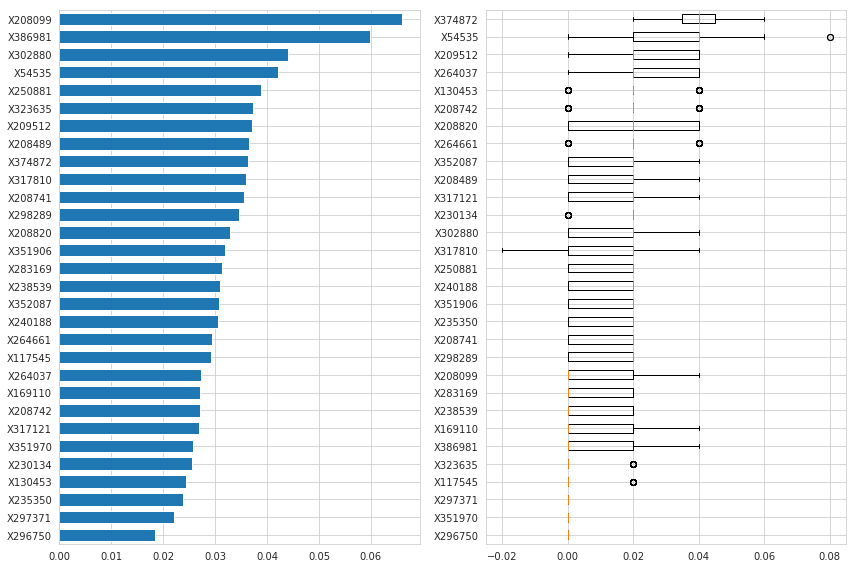

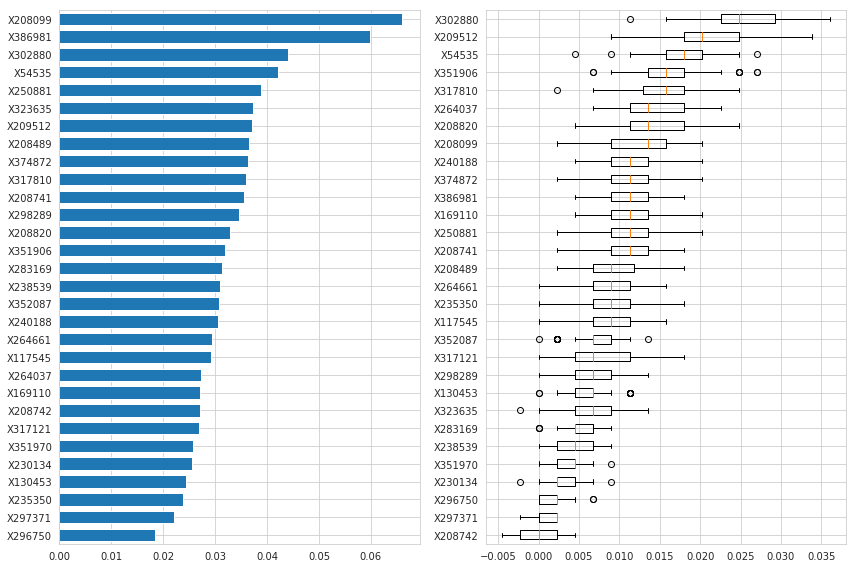

0.9
Test AUC0.8732638888888888
Train AUC0.990506329113924
14


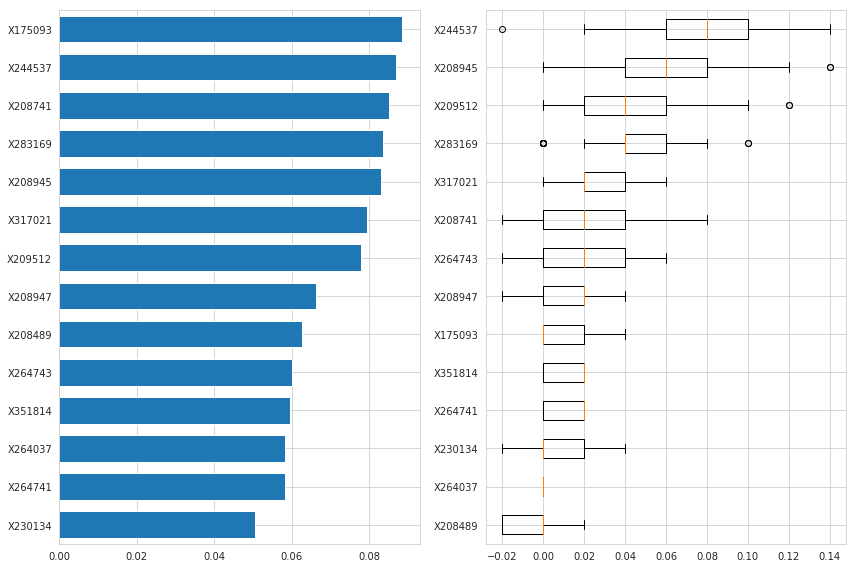

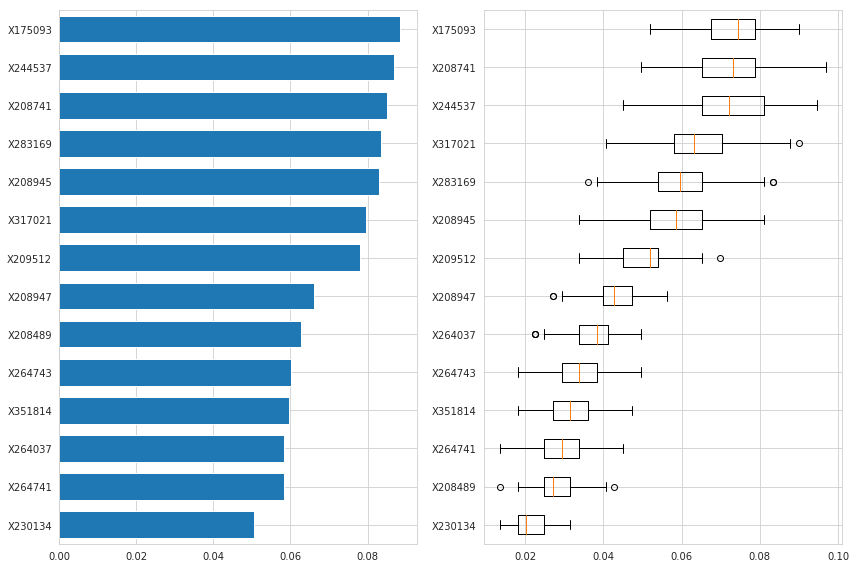

0.86
Test AUC0.8055555555555556
Train AUC0.942374081614588


In [25]:
## half features

random.seed(12345)

for i in ["100","50","30","10"]:
    
    df = pd.read_csv("OutputNCV/RFE_CORR/nselect"+str(i)+"/Fall/FeatureImportance.csv")
    df = df[df['Importance'].cumsum() < 0.5]

    f = (round(df.shape[0]))
    print(f)
    X_seln = X_corr[list(df.iloc[0:f,]["0"])]
    Xval_seln = X_val[list(df.iloc[0:f,]["0"])]

    random.seed(12345)

    ClasRep =  pd.DataFrame()

    ### Fit on whole training data ## 
    ### Test on validation/hold out data set ##


    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.15, random_state=12345)
    rf = RandomForestClassifier(random_state=1)
    
    ## define search space
    
    space = dict()
    space['n_estimators'] = [50, 100,200, 250,300]
    space['max_depth'] = [4, 6, 8,10]
    search = GridSearchCV(rf, space, scoring='roc_auc', cv=sss, refit=True)
    search.fit(X_seln,y)
    cv_results = search.cv_results_
    rf_cv = search.best_estimator_
    yhat = rf_cv.predict(Xval_seln)
    probas_ = rf_cv.predict_proba(Xval_seln)
    yThat = rf_cv.predict(X_seln)

    ## Features Importance ##

    features = X_seln.columns
    importances = rf_cv.feature_importances_
    indices = np.argsort(importances)[::-1]
    feat_imp_RF = (pd.DataFrame(np.flipud([features[z] for z in indices])))
    feat_imp_RF['Importance'] = importances

    ## Feature Permutation on Test
        
    resultp = permutation_importance(rf_cv, Xval_seln, y_val, n_repeats=100, n_jobs=-1)
    perm_sorted_idx = resultp.importances_mean.argsort()
    permutations = pd.DataFrame({'Feature':Xval_seln.columns.values[perm_sorted_idx][::-1],'Mean':resultp.importances_mean[perm_sorted_idx][::-1],
                          'std':resultp.importances_std[perm_sorted_idx][::-1]})
    PermutResultst = permutations
   
    ##plot
    tree_importance_sorted_idx = np.argsort(rf_cv.feature_importances_)
    tree_indices = np.arange(0, len(rf_cv.feature_importances_)) + 0.5

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    ax1.barh(tree_indices, rf_cv.feature_importances_[tree_importance_sorted_idx], height=0.7)
    ax1.set_yticks(tree_indices)
    ax1.set_yticklabels(Xval_seln.columns[tree_importance_sorted_idx])
    ax1.set_ylim((0, len(rf_cv.feature_importances_)))
    ax2.boxplot(
        resultp.importances[perm_sorted_idx].T,
        vert=False,
        labels=Xval_seln.columns[perm_sorted_idx],
    )
    fig.tight_layout()
    plt.show()
    
    ## Feature Permutation on Train
    
    resultp = permutation_importance(rf_cv, X_seln, y, n_repeats=100, n_jobs=-1)
    perm_sorted_idx = resultp.importances_mean.argsort()
    permutations = pd.DataFrame({'Feature':X_seln.columns.values[perm_sorted_idx][::-1],'Mean':resultp.importances_mean[perm_sorted_idx][::-1],
                          'std':resultp.importances_std[perm_sorted_idx][::-1]})
    PermutResultsT = permutations
    
    ##plot
    tree_importance_sorted_idx = np.argsort(rf_cv.feature_importances_)
    tree_indices = np.arange(0, len(rf_cv.feature_importances_)) + 0.5

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    ax1.barh(tree_indices, rf_cv.feature_importances_[tree_importance_sorted_idx], height=0.7)
    ax1.set_yticks(tree_indices)
    ax1.set_yticklabels(X_seln.columns[tree_importance_sorted_idx])
    ax1.set_ylim((0, len(rf_cv.feature_importances_)))
    ax2.boxplot(
        resultp.importances[perm_sorted_idx].T,
        vert=False,
        labels=X_seln.columns[perm_sorted_idx],
    )
    fig.tight_layout()
    plt.show()
    
    
    ## evaluate the model ##

    acc = accuracy_score(y_val, yhat)
    print(acc)

    ## AUROC test ##
    rf_roc_auc = roc_auc_score(y_val,yhat)

    print("Test AUC"+str(rf_roc_auc))
    auroc_te = (rf_roc_auc) 

    ## AUROC train ##
    
    rf_roc_auc = roc_auc_score(y,yThat)
    print("Train AUC"+str(rf_roc_auc))
    auroc_tr = (rf_roc_auc) 

    ## Save Test Predictions
    
    data = {'Index': (y_val.index),
                'AET':y_val,
                    'Predictions':yhat, 
                   "Split":"Test",
                   "Iteration":i}
    Ptest = pd.DataFrame(data)
    tPredictions = Ptest
    
        ## Save Train Predictions
        
    data = {'Index': (y.index),
                    'AET':y,
                        'Predictions':yThat, 
                       "Split":"Train",
                       "Iteration":i}
    Ptrain = pd.DataFrame(data)
    TPredictions = Ptrain

    ## Scores ##
    
    cr = (classification_report(y_val, yhat,output_dict=True))
    cr = pd.DataFrame.from_dict(cr).T
    ClasRep = pd.concat([ClasRep,cr])
    
    ## Save the model
    
    joblib.dump(rf_cv, "OutputNCV/RFE_CORR/nselect"+str(i)+"/random_forest.joblib")
#     path="OutputNCVFinal/OuterGroupRFECV/RFE_CORR/nselect"+str(i)+"/Fall2.2/"
    

    ## Save Feature Importance
    
    df = pd.DataFrame.from_dict(feat_imp_RF).sort_values(by=['Importance'],ascending=False)
#     df = df[df['Importance'].cumsum() < 0.8]
#     df.to_csv(path+"FeatureImportance.csv")

#     ## Save Permutation Importance
#     PermutResultst.to_csv(path+"PermutResultsTest.csv")
#     PermutResultsT.to_csv(path+"PermutResultsTrain.csv")

#     ## Save Classification Report
#     ClasRep.to_csv(path+"ClasRep.csv")

#     ## Save AUC
#     pd.DataFrame([auroc_te]).to_csv(path+"AUROCtest.csv")
#     pd.DataFrame([auroc_tr]).to_csv(path+"AUROCtrain.csv")
    
#         ## Save Individual Predictions
#     pd.DataFrame(TPredictions).to_csv(path+"TPredictions.csv")
#     pd.DataFrame(tPredictions).to_csv(path+"tPredictions.csv")

In [14]:
Xval_seln.columns

Index(['X238617', 'X209079', 'X264585', 'X207588', 'X250881', 'X150556',
       'X208592', 'X281036', 'X317121', 'X353342',
       ...
       'X169332', 'X276451', 'X298289', 'X7555', 'X351814', 'X416548',
       'X336094', 'X297371', 'X352087', 'X264588'],
      dtype='object', length=126)

In [22]:
## half features

random.seed(12345)

for i in ["55","40","35","30","25","20","15"]:
    
    df = pd.read_csv("OutputNewNCV/OuterGroupRFECV/RFE_CORR/nselect30/Fall2/FeatureImportance.csv")
#     df = df[df['Importance'].cumsum() < 0.7]

    f = (round(df.shape[0]))
    print(f)
    X_seln = X_corr[list(df.iloc[0:f,]["0"])]
    Xval_seln = X_val[list(df.iloc[0:f,]["0"])]

    random.seed(12345)

    ClasRep =  pd.DataFrame()

    ### Fit on whole training data ## 
    ### Test on validation/hold out data set ##


    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.15, random_state=12345)
    rf = RandomForestClassifier(random_state=1)
    #         # define search space
    space = dict()
    space['n_estimators'] = [50, 100,200, 250,300]
    space['max_depth'] = [4, 6, 8,10]
    search = GridSearchCV(rf, space, scoring='roc_auc', cv=sss, refit=True)
    search.fit(X_seln,y)
    cv_results = search.cv_results_
    rf_cv = search.best_estimator_
#     yhat = rf_cv.predict(Xval_seln)
#     probas_ = rf_cv.predict_proba(Xval_seln)
#     yThat = rf_cv.predict(X_seln)
    n_features_to_select = int(i)  # Minimum number of features to consider
    rfe = RFE(estimator=rf_cv,n_features_to_select=n_features_to_select,step=1)
    rfe.fit(X_seln, y)


    ## Extract selected features ##

    f = rfe.get_support(1)
    X_tr_rfe = X_seln[X_seln.columns[f]] 
    X_val_rfe = Xval_seln[X_seln.columns[f]] 

    ## fit again on whole training with selected features ##
    rf_rfe = rf_cv.fit(X_tr_rfe,y)
    yhat = rf_rfe.predict(X_val_rfe)
    yThat = rf_rfe.predict(X_tr_rfe)
#     Features.append(list(X_val_rfe.columns))
        

    ## Features Importance ##
    features = X_val_rfe.columns
    # Fmodels[i] = rf_rfe
    importances = rf_cv.feature_importances_
    indices = np.argsort(importances)[::-1]
    feat_imp_RF = (pd.DataFrame(np.flipud([features[z] for z in indices])))
    feat_imp_RF['Importance'] = importances

        ## Feature Permutation on Test
    resultp = permutation_importance(rf_cv,X_val_rfe , y_val, n_repeats=100, n_jobs=-1)
    perm_sorted_idx = resultp.importances_mean.argsort()
    permutations = pd.DataFrame({'Feature':X_val_rfe.columns.values[perm_sorted_idx][::-1],'Mean':resultp.importances_mean[perm_sorted_idx][::-1],
                          'std':resultp.importances_std[perm_sorted_idx][::-1]})
    PermutResultst = permutations
    
            ## Feature Permutation on Train
    resultp = permutation_importance(rf_cv, X_tr_rfe, y, n_repeats=100, n_jobs=-1)
    perm_sorted_idx = resultp.importances_mean.argsort()
    permutations = pd.DataFrame({'Feature':X_tr_rfe.columns.values[perm_sorted_idx][::-1],'Mean':resultp.importances_mean[perm_sorted_idx][::-1],
                          'std':resultp.importances_std[perm_sorted_idx][::-1]})
    PermutResultsT = permutations
    
    ## evaluate the model ##

    acc = accuracy_score(y_val, yhat)
    print(acc)

    ## AUROC test ##
    rf_roc_auc = roc_auc_score(y_val,yhat)

    print("Test AUC"+str(rf_roc_auc))
    auroc_te = (rf_roc_auc) 

    ## AUROC train ##
    rf_roc_auc = roc_auc_score(y,yThat)
    print("Train AUC"+str(rf_roc_auc))
    auroc_tr = (rf_roc_auc) 

    ## Save Test Predictions
    data = {'Index': (y_val.index),
                'AET':y_val,
                    'Predictions':yhat, 
                   "Split":"Test",
                   "Iteration":i}
    Ptest = pd.DataFrame(data)
    tPredictions = Ptest
        ## Save Train Predictions
    data = {'Index': (y.index),
                    'AET':y,
                        'Predictions':yThat, 
                       "Split":"Train",
                       "Iteration":i}
    Ptrain = pd.DataFrame(data)
    TPredictions = Ptrain

    ## Scores ##
    cr = (classification_report(y_val, yhat,output_dict=True))
    cr = pd.DataFrame.from_dict(cr).T
    ClasRep = pd.concat([ClasRep,cr])

    
    import os 
    
    # Directory 
    directory = "ns"+str(i)
    
    # Parent Directory path 
    parent_dir = "OutputNewNCV/OuterGroupRFECV/RFE_CORR/nselect30/Fall3/"
    
    # Path 
    path = os.path.join(parent_dir, directory) 
    
    # Create the directory 
    # 'GeeksForGeeks' in 
    # '/home / User / Documents' 
    os.mkdir(path) 

    path="OutputNewNCV/OuterGroupRFECV/RFE_CORR/nselect30/Fall3/ns"+str(i)+"/"
    

    ## Save Feature Importance
    df = pd.DataFrame.from_dict(feat_imp_RF).sort_values(by=['Importance'],ascending=False)
#     df = df[df['Importance'].cumsum() < 0.8]
    df.to_csv(path+"FeatureImportance.csv")

    ## Save Permutation Importance
    PermutResultst.to_csv(path+"PermutResultsTest.csv")
    PermutResultsT.to_csv(path+"PermutResultsTrain.csv")

    ## Save Classification Report
    ClasRep.to_csv(path+"ClasRep.csv")

    ## Save AUC
    pd.DataFrame([auroc_te]).to_csv(path+"AUROCtest.csv")
    pd.DataFrame([auroc_tr]).to_csv(path+"AUROCtrain.csv")
    
        ## Save Individual Predictions
    pd.DataFrame(TPredictions).to_csv(path+"TPredictions.csv")
    pd.DataFrame(tPredictions).to_csv(path+"tPredictions.csv")

60
0.84
Test AUC0.8020833333333333
Train AUC0.9602770647074443
60
0.82
Test AUC0.7864583333333333
Train AUC0.9648579268832433
60
0.84
Test AUC0.8020833333333333
Train AUC0.9536160042489156
60
0.8
Test AUC0.7708333333333333
Train AUC0.9564486146764628
60
0.82
Test AUC0.7864583333333333
Train AUC0.9536160042489156
60
0.82
Test AUC0.7986111111111112
Train AUC0.9448747455076569
60
0.82
Test AUC0.7864583333333333
Train AUC0.9227228467734796


In [4]:
import pandas as pd
import numpy as np
# Create feature matrix with two highly correlated features

X = np.array([[1, 1, 1],
          [2, 2, 0],
          [3, 3, 1],
          [4, 4, 0],
          [5, 5, 1],
          [6, 6, 0],
          [7, 7, 1],
          [8, 7, 0],
          [9, 7, 1]])

# Convert feature matrix into DataFrame
df = pd.DataFrame(X)

# View the data frame
df

# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
# Drop features 
df.drop(df[to_drop], axis=1)

,0,2
0,1,1
1,2,0
2,3,1
3,4,0
4,5,1
5,6,0
6,7,1
7,8,0
8,9,1


In [7]:
len(to_drop)

1